# Работа с API ВКонтакте

В этой домашке мы:

1. Научимся работать с API ВКонтакте (вытягивать оттуда данные без необходимости парсить страницы, что долго и дорого).
2. Научимся визуализировать графы и рассчитывать характеристики центральности на них.

Про то, как работает API VK, можно долго читать в его официальной документации: https://vk.com/dev/methods

<a href = 'https://ru.wikipedia.org/wiki/Теория_графов'>Теория графов</a>  - отдельный большой предмет. Из него нам сегодня будет необходимо только определение графов, а также понятие <a href = 'https://en.wikipedia.org/wiki/Centrality'>центральности</a>.

Ну, а про приложения теории графов к соцсетям можно посмотреть в <a href = 'https://socialdatahub.com/noindex/presentations/primenenie_teorii_grafov_k_sotsialnyim_setyam'>лекции</a> Артура Хачуяна.

Для любителей книг предлагаются три издания:

* ”Networks, Crowds, and Markets: Reasoning About a Highly
Connected World”. David Easley and John Kleinberg, Cambridge
University Press 2010.

* ”Social Network Analysis. Methods and Applications”. Stanley
Wasserman and Katherine Faust, Cambridge University Press, 1994

* ”Networks: An Introduction”. Mark Newman. Oxford University Press,
2010.

## Технические требования

1. Что нужно установить: библиотеку <a href = 'https://networkx.github.io/documentation/networkx-1.9/index.html'>networkx</a> для работы с графами (давно привычной вам командой pip), библиотеку community (https://bitbucket.org/taynaud/python-louvain) для поиска сообществ в графе.
2. Как получить доступ к API ВКонтакте: создать токен (схема есть <a href = 'http://all-for-vkontakte.ru/catalog/access-token-vkontakte'>например, здесь</a>).

Создайте себе токен и пропишите в переменную token ниже.

In [1]:
token = 'впишитесюда'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family': 'Verdana','weight': 'normal'}
rc('font', **font)

## Информация о пользователе

В переменную link впишите id пользователя, профиль которого вы будете изучать - например, свой.

In [3]:
link = 'dale.david'

Библиотека urllib.request умеет запрашивать какие-то адреса в Интернете и получать ответ в виде строки.

Мы сотворим запрос к API VK, чтобы полусить информацию о пользователе с данной ссылкой.

In [4]:
import urllib.request
user_info_raw = urllib.request.urlopen('https://api.vk.com/method/users.get?users_ids='+link+'&access_token='+token
                                  ).read().decode('utf-8')
print(user_info_raw)
print(type(user_info_raw))


{"response":[{"uid":9032467,"first_name":"Давид","last_name":"Дале"}]}
<class 'str'>


В ответ от VK мы получили текстовую строку, но она очень похожа на питоновский объект по виду (он называется JSON). Чтобы воссоздать объект (словарь со списком из словаря), мы распарсим его одноименной библиотекой json

In [5]:
import json
user_info = json.loads(user_info_raw)
print(user_info)
print(type(user_info))

{'response': [{'last_name': 'Дале', 'first_name': 'Давид', 'uid': 9032467}]}
<class 'dict'>


Нас интересует только первый пользователь в списке (их могло быть много):

In [6]:
user = user_info['response'][0]
user

{'first_name': 'Давид', 'last_name': 'Дале', 'uid': 9032467}

## Общие группы

Рассмотрим, в каких публичных группах состоит данный пользователь. 

Групп может быть больше 1000, а один запрос возвращает не больше 1000 объектов, поэтому сделаем цикл из нескольких возможных запросов.

In [7]:
offset = 0
groups = dict()
while(True):
    _groups = json.loads(urllib.request.urlopen('https://api.vk.com/method/groups.get?user_id='+str(user['uid'])
                                                +'&extended=1&count=1000&offset='+str(offset)+'&access_token='+token
                                               ).read().decode('utf-8'))
    if len(_groups['response']) > 0 and len(_groups['response'][1]) > 0:
        for group in _groups['response'][1:]:
            if 'gid' in group:
                groups[group['gid']] = group['name']
        if _groups['response'][0] > 1000:
            offset += 1000
        else:
            break
    else:
        break

In [8]:
groups

{998490: 'Русский Репортер',
 11283947: 'Яндекс',
 11982368: 'Forbes',
 16108331: 'Программирование ITmozg:',
 22334840: 'Английский клуб English Games',
 23391543: 'Матметоды.рф',
 23995866: 'E:\\music\\',
 25058639: 'Devilishly positive person',
 25205856: 'Высшая школа экономики',
 26221235: 'Reggae Side • Выбирай Регги',
 26517977: '«Эксперт» Online',
 30441641: 'Мемы HSE',
 31798109: 'PwC Junior Club',
 32342123: 'Societe Financiers',
 33393308: 'Стартапы и бизнес',
 33415527: 'McKinsey Business Diving 2017',
 35555742: 'Кейс Клуб МФТИ',
 37390080: 'Будь лучше! - Стажировки, конкурсы, стипендии',
 37891110: 'Northernrain',
 40710398: 'Задачник скучающего ботана',
 40821900: 'Волосатые сказки',
 42556983: 'ЦМФ',
 43921957: 'Management Consulting Club',
 45020707: 'Growth Driver',
 45842880: 'The Foundation',
 45964955: 'The Owl and The Cat',
 49815762: 'Data Mining Labs',
 52582182: 'Всероссийский Учебный Марафон "Программист"',
 55508381: 'The Better Game. Ежедневные отчёты',
 555

Подтянем также список друзей нашего пользователя

In [9]:
friends = dict()
_friends = json.loads(urllib.request.urlopen('https://api.vk.com/method/friends.get?user_id='+str(user['uid'])
                                             +'&fields=name&access_token='+token).read().decode('utf-8'))
for friend in _friends['response']:
    if 'uid' in friend and not 'deactivated' in friend:
        friends[friend['uid']] = friend['first_name'] + ' ' + friend['last_name']

In [10]:
len(friends)

822

Запросим группы, в которых состоит каждый друг. Для простоты мы будем брать только первые 1000 групп.

Предупреждение: цикл может быть долгим. Для некоторых пользователей список групп недоступен (закрыт).

In [78]:
friend_groups_common = dict()
friend_groups_data = dict()
for i, uid in enumerate(friends):
    print('{:3d} {:30s}'.format(i, friends[uid]), end = '\t')
    offset = 0
    _groups = json.loads(urllib.request.urlopen('https://api.vk.com/method/groups.get?user_id='+str(uid)
                                                +'&extended=1&count=1000&offset='+str(offset)+'&access_token='
                                                +token).read().decode('utf-8'))
    same_group_count = 0
    if 'response' in _groups:
        friend_groups_data[uid] = _groups['response'][1:]
        for group in _groups['response'][1:]:
            if 'gid' in group:
                if group['gid'] in groups:
                    same_group_count += 1
        print(same_group_count)
    else:
        if 'error' in _groups:
            print(_groups['error']['error_msg'])
        else:
            print('unknown error')
    # Здесь должна быть задержка
    
    friend_groups_common[uid] = same_group_count            

  0 Arshak Minasyan               	Permission to perform this action is denied
  1 Денис Зотов                   	0
  2 Наталия Мещерякова            	2
  3 Павел Венедиктов              	0
  4 Таня Проскурина               	2
  5 Сергей Коротких               	0
  6 Eugen Kolomiets               	0
  7 Андрей Соловьёв               	0
  8 Alisa Potter                  	1
  9 Hochbar Ramazanov             	0
 10 Даша Свистунова               	2
 11 Irina Kurochkina              	4
 12 Курбан Маллачиев              	0
 13 Аля Соколова                  	0
 14 Анастасия Ноговицына          	1
 15 Алиса Сурменева               	Permission to perform this action is denied
 16 Айдар Мусин                   	Permission to perform this action is denied
 17 Ольга Егоян                   	10
 18 Олесь Смага                   	Permission to perform this action is denied
 19 Alla Wy                       	0
 20 Владимир Кондратьев           	4
 21 Георгий Атомян                	Permission to perfo

Поскольку цикл отрабатывал долго, то сейчас самое время сохранить все результаты на диск библиотекой pickle (чтобы не запускать его повторно в случае чего).

In [83]:
import pickle
pickle.dump([user, groups, friends, friend_groups_common, friend_groups_data], open('friends_groups.pkl', 'wb'))

Считываются данные потом так:

In [7]:
import pickle
user, groups, friends, friend_groups_common, friend_groups_data = pickle.load(open('friends_groups.pkl', 'rb'))

Посмотрим на 15 пользователей, которые имею с вами 

In [198]:
for uid in sorted(friend_groups_data, key=friend_groups_common.get, reverse=True)[:15]:
    print('{:30} имеет с вами {} общих групп'.format(friends[uid],friend_groups_common[uid]))

Анна Новикова                  имеет с вами 23 общих групп
Алиса Морозова                 имеет с вами 18 общих групп
Ренат Заяшников                имеет с вами 17 общих групп
Алия Бариева                   имеет с вами 17 общих групп
Ярослав Корякин                имеет с вами 16 общих групп
Миша Бочкарев                  имеет с вами 16 общих групп
Даниил Несинов                 имеет с вами 15 общих групп
Макс Корольков                 имеет с вами 14 общих групп
Бимба Батожаргалов             имеет с вами 14 общих групп
Александр Андреев              имеет с вами 14 общих групп
Аня Бекетова                   имеет с вами 14 общих групп
Ксения Фоминых                 имеет с вами 13 общих групп
Мария Кащеева                  имеет с вами 12 общих групп
Тимур Хафизов                  имеет с вами 12 общих групп
Na Stja                        имеет с вами 11 общих групп


Зная, в каких группах состоит каждый из пользователей, можно было бы, например, обучить тематическую модель групп, чтобы выделить похожие группы и пользователей с похожими интересами. Попробуйте!

## Эгоцентрический граф друзей

Подобно тому, как мы достали список групп каждого пользователя, можно достать списки их друзей. 

Мы хотим создать граф только из друзей первого пользователя, поэтому в словарь friends_of_friends мы запишем только связи между друзьями первого порядка (не будем включать туда друзей друзей).

In [203]:
friends_of_friends = dict()
for i, uid in enumerate(friends):
    print('{:3d} {:30s}'.format(i, friends[uid]), end = '\t')
    _friends = json.loads(urllib.request.urlopen('https://api.vk.com/method/friends.get?user_id='+str(uid)
                                             +'&fields=name&access_token='+token).read().decode('utf-8'))
    fof = []
    if 'response' in _friends:
        for friend in _friends['response']:
            if 'uid' in friend and not 'deactivated' in friend:
                # возвращаем только общих друзей данного пользователя с центральным
                if friend['uid'] in friends:
                    fof.append(friend['uid'])
        print(len(fof))
    else:
        if 'error' in _friends:
            print(_friends['error']['error_msg'])
        else:
            print('unknown error')
    friends_of_friends[uid] = fof
    

  0 Arshak Minasyan               	36
  1 Денис Зотов                   	45
  2 Наталия Мещерякова            	75
  3 Павел Венедиктов              	3
  4 Таня Проскурина               	8
  5 Сергей Коротких               	81
  6 Eugen Kolomiets               	5
  7 Андрей Соловьёв               	8
  8 Alisa Potter                  	1
  9 Hochbar Ramazanov             	20
 10 Даша Свистунова               	16
 11 Irina Kurochkina              	24
 12 Курбан Маллачиев              	0
 13 Аля Соколова                  	6
 14 Анастасия Ноговицына          	29
 15 Алиса Сурменева               	22
 16 Айдар Мусин                   	36
 17 Ольга Егоян                   	5
 18 Олесь Смага                   	2
 19 Alla Wy                       	1
 20 Владимир Кондратьев           	11
 21 Георгий Атомян                	33
 22 Андрей Маркелов               	2
 23 Егор Гиренко                  	55
 24 Алёша Аппаков                 	18
 25 Дианка Григорьева             	13
 26 Кристина Евтифьева 

In [205]:
import pickle
pickle.dump([friends_of_friends], open('friends_of_friends.pkl', 'wb'))

In [11]:
import pickle
[friends_of_friends] = pickle.load(open('friends_of_friends.pkl', 'rb'))

Теперь подключим библиотеку networkx, которая позволяет проводить расчёты на графах и визуализировать их.

In [12]:
import networkx as nx

Создадим граф, добавив туда только друзей иосновного пользователя и связи между ними.

In [13]:
G = nx.Graph()
G.add_nodes_from(list(friends.keys()))
G.add_edges_from([(i,j) for i in friends_of_friends for j in friends_of_friends[i] if j != user['uid']])

Каков размер графа?

In [14]:
print(G.number_of_nodes(), G.number_of_edges())

822 10075


Воспользуемся готовым алгоритмом визуализации графа. Видим, что есть много точек, ни с кем не связанных.

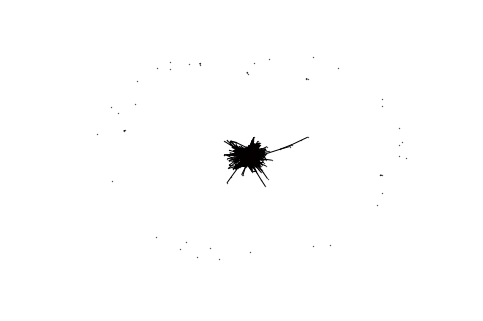

In [15]:
nx.draw(G, node_size  = 0.1)

Оказывается, библиотека networkx умеет отвечать на вопросы о свойствах графа, например, о том, является ли он связным.

In [16]:
nx.is_connected(G)

False

Посчитаем число соединённых компонент в графе.

In [17]:
subgraphs = [sg for sg in nx.connected_component_subgraphs(G)]
print(len(subgraphs))

38


In [18]:
comp_lengths = [len(sg.nodes()) for sg in subgraphs]
print(comp_lengths)

[780, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [19]:
G1 = subgraphs[np.argmax(comp_lengths)]

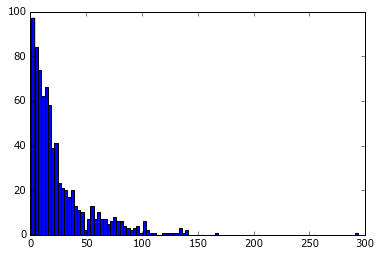

In [61]:
degrees=list(nx.degree(G1).values())
_ = plt.hist(degrees, bins = 100)

Тот алгоритм рисования графа, которым мы воспользовались, основан на воображаемых "пружинках" между узлами.

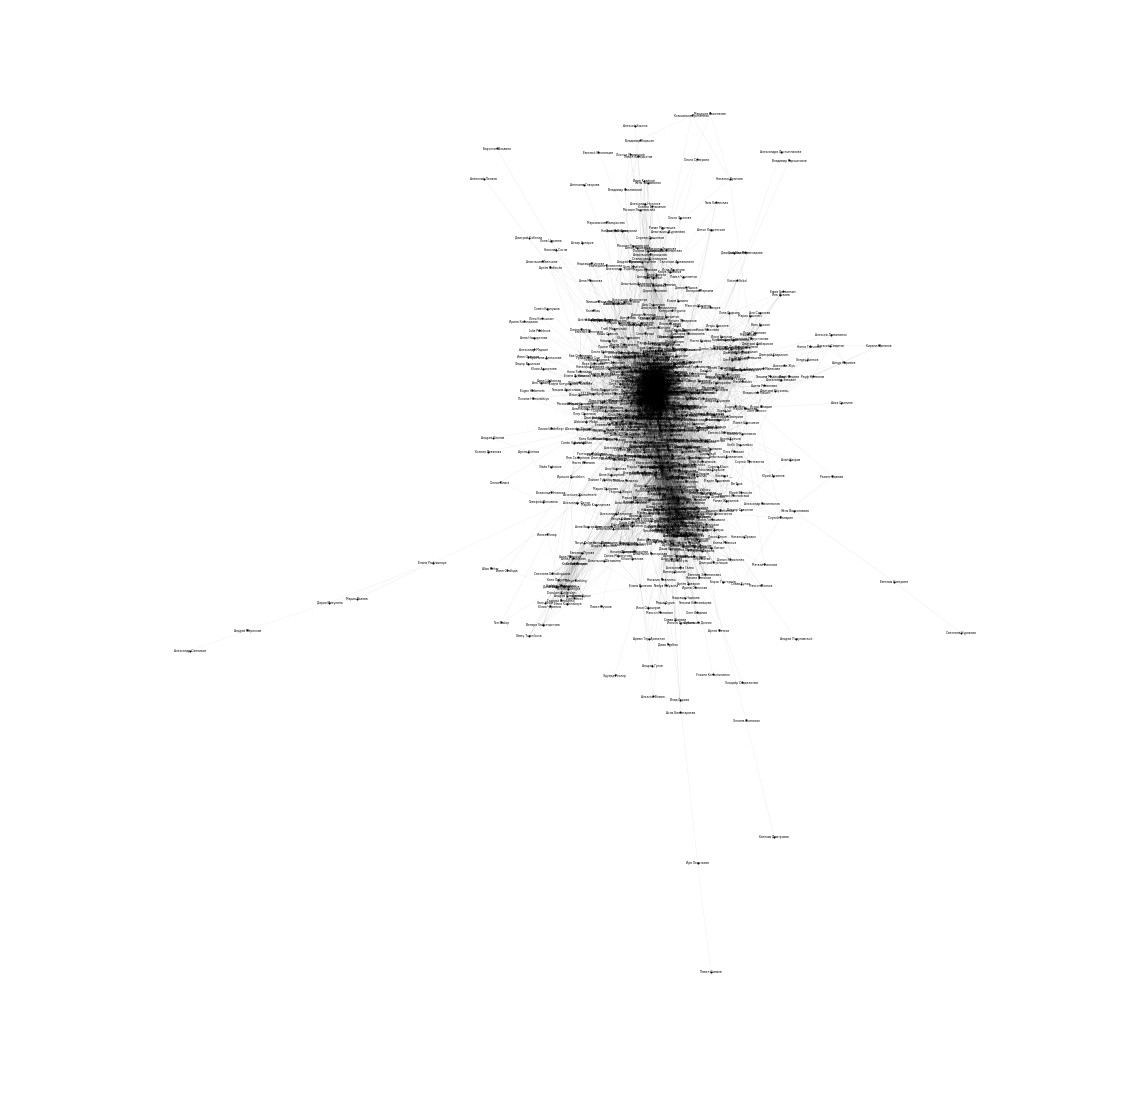

In [20]:
plt.figure(figsize = (15,15))
labels = {f:friends[f] for f in friends if f in G1.nodes()}
nx.draw_spring(G1, node_size = 1, width  = 0.03, labels = labels, font_size = 3, font_family  = 'Verdana')
#

Есть и другие методы визуализации - например, с помощью концентрических окружностей.

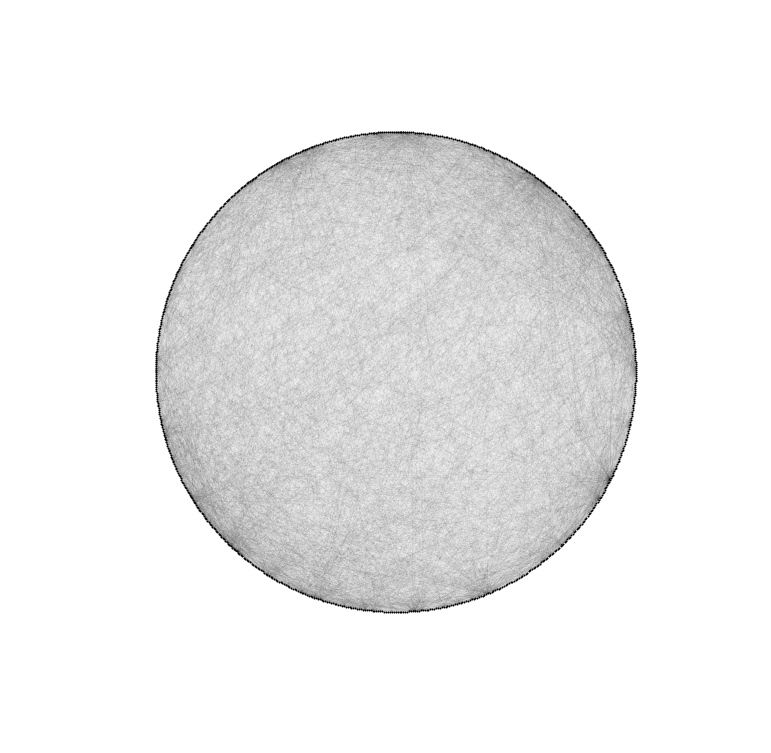

In [21]:
plt.figure(figsize = (10,10))
nx.draw_shell(G1, node_size = 1, width  = 0.01)

Если у вас очень много друзей, можно нарисовать случайный подграф вашего графа

In [84]:
np.random.seed(41)
random_friends = np.random.choice(range(len(G1)), size = 80, replace = False)
all_nodes = G1.nodes()
G2 = G1.subgraph([all_nodes[i] for i in random_friends])
subgraphs2 = [sg for sg in nx.connected_component_subgraphs(G2)]
G2 = subgraphs2[np.argmax([len(sg) for sg in subgraphs2])]
labels2 = {f:friends[f] for f in friends if f in G2.nodes()}

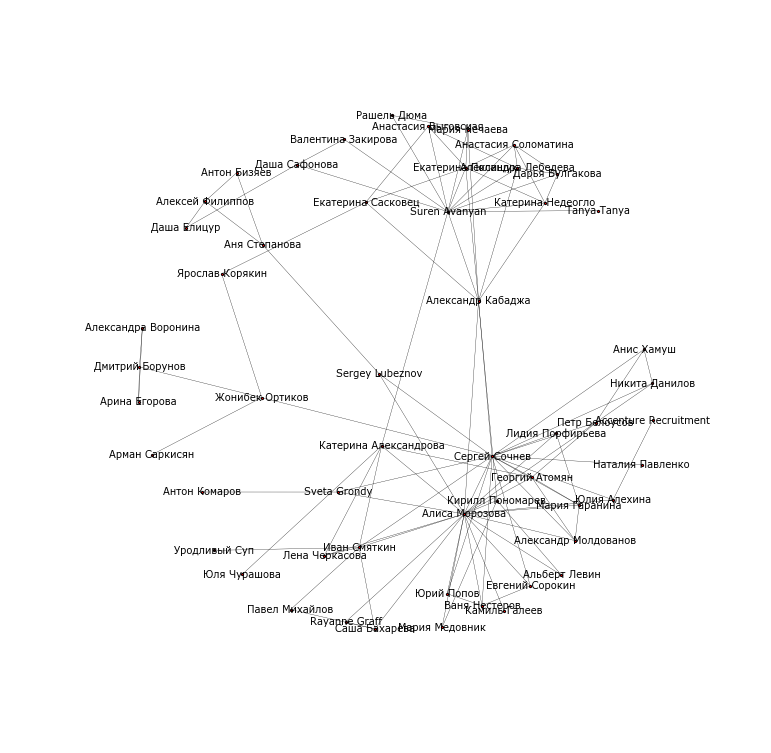

In [85]:
plt.figure(figsize = (10,10))
nx.draw_spring(G2, node_size = 5, width  = 0.3, labels = labels2, font_size = 10, font_family  = 'Verdana')

#### Центральность

https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.centrality.html

In [46]:
di = nx.degree_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has degree centrality {}'.format(friends[uid], di[uid]))

Анна Новикова                  has degree centrality 0.37740693196405645
Алиса Морозова                 has degree centrality 0.21309370988446724
Suren Avanyan                  has degree centrality 0.1797175866495507
Никита Толстой                 has degree centrality 0.1784338896020539
Сергей Сочнев                  has degree centrality 0.17458279845956354
Карина Хусаинова               has degree centrality 0.17329910141206675
Иван Афанасьев                 has degree centrality 0.17201540436456994
Антон Ветров                   has degree centrality 0.17073170731707316
Паша Попов                     has degree centrality 0.16944801026957637
Леша Васин                     has degree centrality 0.165596919127086


In [47]:
di = nx.betweenness_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has betweenness centrality {}'.format(friends[uid], di[uid]))

Анна Новикова                  has betweenness centrality 0.20568588348836173
Алиса Морозова                 has betweenness centrality 0.06387588093474186
Никита Толстой                 has betweenness centrality 0.04189305692241117
Виктор Козлов                  has betweenness centrality 0.034716077776375406
Светлана Погребняк             has betweenness centrality 0.0324854886450277
Валерий Окунев                 has betweenness centrality 0.03029813555475299
Иван Афанасьев                 has betweenness centrality 0.03019305673550201
Сергей Сочнев                  has betweenness centrality 0.029181639128624245
Александр Алексеев             has betweenness centrality 0.027085126760867134
Катюша Ларшина                 has betweenness centrality 0.026111013308278017


In [48]:
di = nx.closeness_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has closeness centrality {}'.format(friends[uid], di[uid]))

Анна Новикова                  has closeness centrality 0.5888133030990174
Алиса Морозова                 has closeness centrality 0.5172642762284196
Никита Толстой                 has closeness centrality 0.5009646302250804
Катюша Байнова                 has closeness centrality 0.4914826498422713
Иван Афанасьев                 has closeness centrality 0.48932160804020103
Виктор Козлов                  has closeness centrality 0.4884012539184953
Паша Попов                     has closeness centrality 0.4880952380952381
Светлана Погребняк             has closeness centrality 0.48475420037336653
Карина Хусаинова               has closeness centrality 0.48385093167701865
Arman Sein                     has closeness centrality 0.4826517967781908


In [49]:
di = nx.eigenvector_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has eigenvector centrality {}'.format(friends[uid], di[uid]))

Анна Новикова                  has eigenvector centrality 0.18530815663579547
Suren Avanyan                  has eigenvector centrality 0.14257585011031307
Антон Ветров                   has eigenvector centrality 0.14164330227433905
Леша Васин                     has eigenvector centrality 0.13962275574017874
Ольга Шиханцова                has eigenvector centrality 0.13443422913188371
Екатерина Полищук              has eigenvector centrality 0.12766498165588144
Карина Хусаинова               has eigenvector centrality 0.12512245453392254
Любовь Лисина                  has eigenvector centrality 0.12300615003643535
Паша Попов                     has eigenvector centrality 0.12272514303400227
Irina Ivchenkova               has eigenvector centrality 0.1178352662293413


#### Сообщества

In [76]:
import community
partition = community.best_partition(G1)
partition_values = set(partition.values())

In [77]:
for ci in partition_values:
    print([friends[i] for i in partition if partition[i] == ci])

['Arshak Minasyan', 'Таня Проскурина', 'Tanya Grunina', 'Na Stja', 'Маша Герасименко', 'Олег Колодников', 'Рашид Нураденов', 'Вася Васильев', 'Эльмира __', 'Данил Шилкин', 'Александр Дмитриев', 'Дмитрий Махотин', 'Maria Lysyuk', 'Коля Кац', 'Ляйсан Губайдулина', 'Саша Левкун', 'Евгеша Козловская', 'Евгения Рязанова', 'Даня Карабекян', 'Наталья Прядко', 'Kirill Yatsushko', 'Филипп Веселов', 'Борис Демешев', 'Irina Kurochkina', 'Юля Чурашова', 'Тимур Хафизов', 'Даниил Герчик', 'Максим Шикин', 'Григорий Хацевич', 'Мария Медовник', 'Евгений Скопинцев', 'Данил Фёдоровых', 'Карина Файзуллина', 'Алексей Макарьин', 'Павел Черепанов', 'Константин Переяслов', 'Лиза Ореханова', 'Наська Кузнецова', 'Андрей Зубанов', 'Иван Станкевич', 'Кирилл Пономарев', 'Лев Феофанов', 'Светлана Погребняк', 'Даша Елицур', 'Иван Вашенцев', 'Ренат Заяшников', 'Сергей Сергеевич', 'Альберт Левин', 'Александра Никитина', 'Влад Корчевой', 'Дина Якуб', 'Daniel Labazanov', 'Саша Кузнецова']
['Денис Зотов', 'Наталия Мещеря

In [87]:
from matplotlib.pyplot import cm 
color=cm.rainbow(np.linspace(0,1,len(partition_values)))

In [93]:
pos = nx.spring_layout(G1)

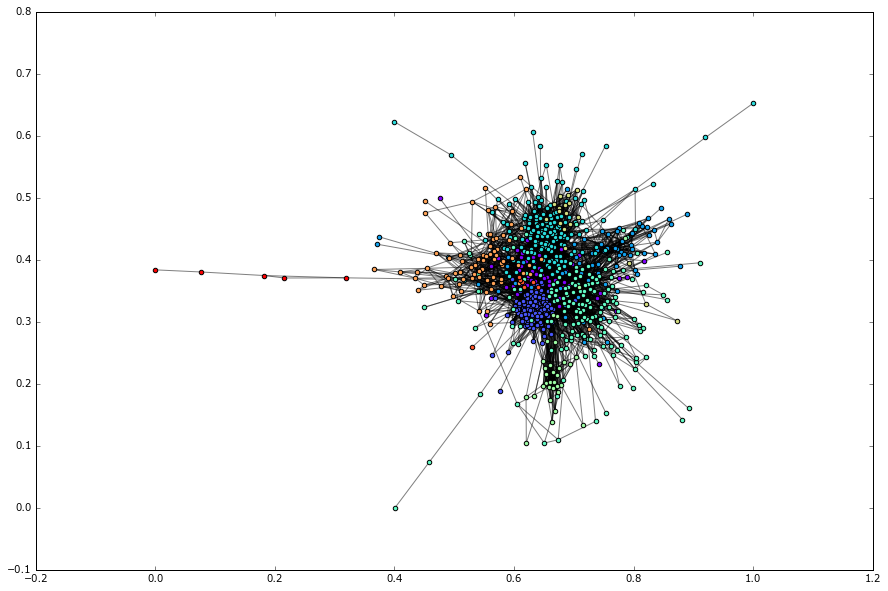

In [95]:
plt.figure(figsize = (15,10))
for count, com in enumerate(partition_values):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, list_nodes, node_size = 20, node_color = color[count])
nx.draw_networkx_edges(G1, pos, alpha=0.5)
plt.show()

При желании, можно нарисовать и раскрашенный подграф

In [100]:
pos = nx.spring_layout(G2)

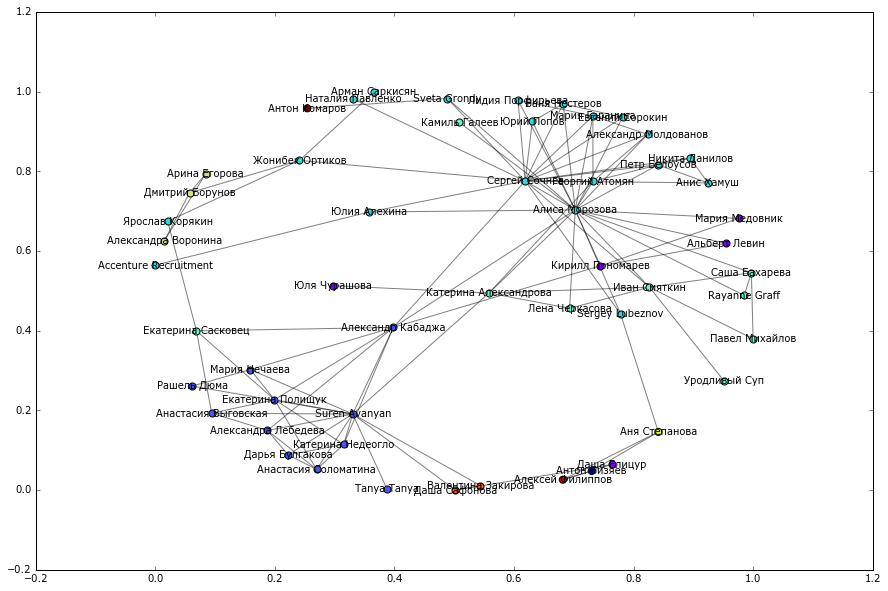

In [101]:
plt.figure(figsize = (15,10))
for count, com in enumerate(partition_values):
    list_nodes = [node for node in partition.keys() if partition[node] == com and node in G2]
    nx.draw_networkx_nodes(G2, pos, list_nodes, node_size = 50, node_color = color[count])
nx.draw_networkx_edges(G2, pos, alpha=0.5)
nx.draw_networkx_labels(G2, pos, labels=labels2, font_size=10, font_family='Verdana')
plt.show()